In [1]:
#pip install fancyimpute scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

## Load data

In [4]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)

## DATA CLEANING

## Simplification of categories

In [5]:
# Merge sports data and extract sports categories
def extract_sports_category(dataset, sports_code):
    merged = pd.merge(dataset, sports_code, left_on="Sports", right_on="Code")
    merged["Sports_Category"] = merged["Categorie"]
    return merged[["PRIMARY_KEY", "Sports_Category"]]

learn_sports = extract_sports_category(learn_dataset_sport, code_Sports)
test_sports = extract_sports_category(test_dataset_sport, code_Sports)

# Merge departments into regions and extract relevant region columns
def merge_and_extract_region(df, merge_column, region_column_name):
    merged = pd.merge(df, departments, left_on=merge_column, right_on="DEP", how="left")
    merged[region_column_name] = merged["REG"]
    return merged.drop(["Nom du département", "REG", "DEP", merge_column], axis=1)

In [6]:
learn_dataset_job = merge_and_extract_region(learn_dataset_job, "JOB_DEP", "JOB_REG")    #put the column as int 
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

test_dataset_job = merge_and_extract_region(test_dataset_job, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

In [7]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

In [8]:
code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

#issue in the code IZ should be its own category "Hébergement et restauration"
#HZ, JZ à MC so LZ, KZ, MA, MB and MC, NZ, OZ, PZ,  QA, QB, RZ, SZ, TZ et UZ should be in the same category

In [9]:
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

## Merging

In [10]:
learn_data = learn_dataset

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)  #should also drop act ?
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#for imputation fitting
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_adm, on="INSEE_CODE", how="left")
learn_data = merge_and_extract_region(learn_data, "DEP", "CURRENT_REG")

test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

test_data = pd.merge(test_data, city_pop, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_loc, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_adm, on="INSEE_CODE", how="left")
test_data = merge_and_extract_region(test_data, "DEP", "CURRENT_REG")

In [11]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, 
             learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, 
            test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [12]:
# Function to combine columns ending with `_x` and `_y` into a single base column
def combine_duplicate_columns(dataframe):
    for column in dataframe.columns:
        if column.endswith('_x'):
            base_column = column[:-2]  # Remove `_x` suffix
            y_column = base_column + '_y'
            if y_column in dataframe.columns:
                # Combine the `_x` and `_y` columns
                dataframe[base_column] = dataframe[column].fillna(dataframe[y_column])
                # Drop the original `_x` and `_y` columns
                dataframe.drop(columns=[column, y_column], inplace=True)
    return dataframe

In [13]:
learn_data = combine_duplicate_columns(learn_data)
test_data = combine_duplicate_columns(test_data)

## Formatting 

In [14]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None 

In [15]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)

In [16]:
def combine_columns(primary_col, fallback_col): #this is imputation
    """Combine two columns, filling missing values in the primary column with values from the fallback column."""
    return primary_col.fillna(fallback_col) if fallback_col is not None else primary_col 

def preprocess_employee_data(data, economic_sector_code, work_description_map):
    data["employee_count"] = data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
    data["Employer_category"] = data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
    
    
    data = data.merge(economic_sector_code, left_on="Economic_sector", right_on="Code", how="left")
    
    # Merge with work description map and clean up columns
    data = data.merge(work_description_map, left_on="work_description", right_on="N3", how="left")
    data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
    data["work_description"] = data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
    data.drop("N1", axis=1, inplace=True)
    
    # Combine relevant columns for contracts and pay
    data["emp_contract"] = combine_columns(data["emp_contract"], data["former_emp_contract"])
    data["Pay"] = combine_columns(data["Pay"], data["RETIREMENT_PAY"])
    data["JOB_REG"] = combine_columns(data["JOB_REG"], data["FORMER_REG"])  
    data["FORMER_REG"] = combine_columns(data["FORMER_REG"], data["JOB_REG"])
    data.loc[~data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_REG'] = combine_columns(data['JOB_REG'], data['CURRENT_REG'])
 
    return data

In [17]:
learn_data = preprocess_employee_data(learn_data, code_Economic_sector, code_work_description_map)
test_data = preprocess_employee_data(test_data, code_Economic_sector, code_work_description_map)

In [18]:
def preprocess_column_types(data):
    data["sex"] = pd.factorize(data["sex"])[0]
    data["studying"] = data["studying"].astype("int64")
    data["Sports_Category"] = data["Sports_Category"].fillna(0).astype("int64")
    
    # List of columns to convert to Int64
    int_columns = ["CURRENT_REG", "JOB_REG", "FORMER_REG", "retirement_age", "WORKING_HOURS", "Economic_sector_num", "Pay"]
    
    for col in int_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')
    
    return data

In [19]:
learn_data = preprocess_column_types(learn_data)
test_data = preprocess_column_types(test_data)

# Labelling non-imputable values

In [20]:
def replace_na_with_unemployed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    
    additional_categories = ['Unemployed']     
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & ((data['JOB_42'].astype(str).str.startswith('csp_8')) | (data['act_num'] == 2)), column_name] = 'Unemployed'

# List of columns to process
columns_to_process = [
    "emp_contract", "TYPE_OF_CONTRACT", "WORK_CONDITION", "Employer_category",
    "labor_force_status", "Economic_sector_num", "JOB_REG", "employee_count",
    "FORMER_REG", "work_description", "retirement_age", "FORMER_JOB_42"
]

for column in columns_to_process:
    replace_na_with_unemployed(learn_data, column)
    replace_na_with_unemployed(test_data, column)

In [21]:
def replace_na_with_employed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    additional_categories = ['Employed']     
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    data.loc[(data[column_name].isna()) & (data['act_num'] == 1), column_name] = 'Employed'

columns_to_process = [ 
    "FORMER_REG", "retirement_age", "FORMER_JOB_42"
]

for column in columns_to_process:
    replace_na_with_employed(learn_data, column)
    replace_na_with_employed(test_data, column)

In [22]:
def clean_data(data, drop_columns):
    #simplify JOB_42?
    data["JOB_42_simple"] = data["JOB_42"].str.extract(r'csp_(\d+)_\d+')[0].astype("Int64")

    # Fill missing Pay and WORKING_HOURS for unemployed
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['Pay'].isna()), 'Pay'] = 0
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0
    
    return data.drop(columns=drop_columns)


# Define columns to drop for each dataset
drop_columns = [
    "act", "former_emp_contract", "RETIREMENT_PAY", 
    "Economic_sector", "Code", "Libellé", "municipality_type",
    "Nomenclature", "X", "Y", "INSEE_CODE", "Nom de la commune"
]

In [23]:
learn_data = clean_data(learn_data, drop_columns)
test_data = clean_data(test_data, drop_columns)

#make sure to drop one of the JOB_42 cols later - simplified or not

#  Investigate reason for missing values 

In [24]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns


# Convert the missing values table to LaTeX format
#latex_learn_data = missing_values_learn_data.to_latex(index=False, float_format="%.2f")
#latex_test_data = missing_values_test_data.to_latex(index=False, float_format="%.2f")

#with open("./missing_values_learn_data.tex", "w") as file:
#    file.write(latex_learn_data)
#with open("./missing_values_test_data.tex", "w") as file:
#    file.write(latex_test_data)

In [25]:
print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8317               16.6
employee_count                 8129               16.2
WORKING_HOURS                  6957               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
FORMER_REG                     2418                4.8
JOB_REG                        2418                4.8
There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8260               16.5
employee_count                 8080               16.1
WORKING_HOURS                  6879               13.7
Pay                       

In [26]:
def plot_na_correlation(df):
    """
    Plots the correlation matrix of missing values in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame with missing values.
    """
    # Calculate correlation of missing values
    missing_corr = df.isnull().corr()

    # Mask to hide the upper triangle
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar=True)
    plt.title("Correlation of Missing Values")
    plt.show()

Correlation of Missing Values for Learn Data


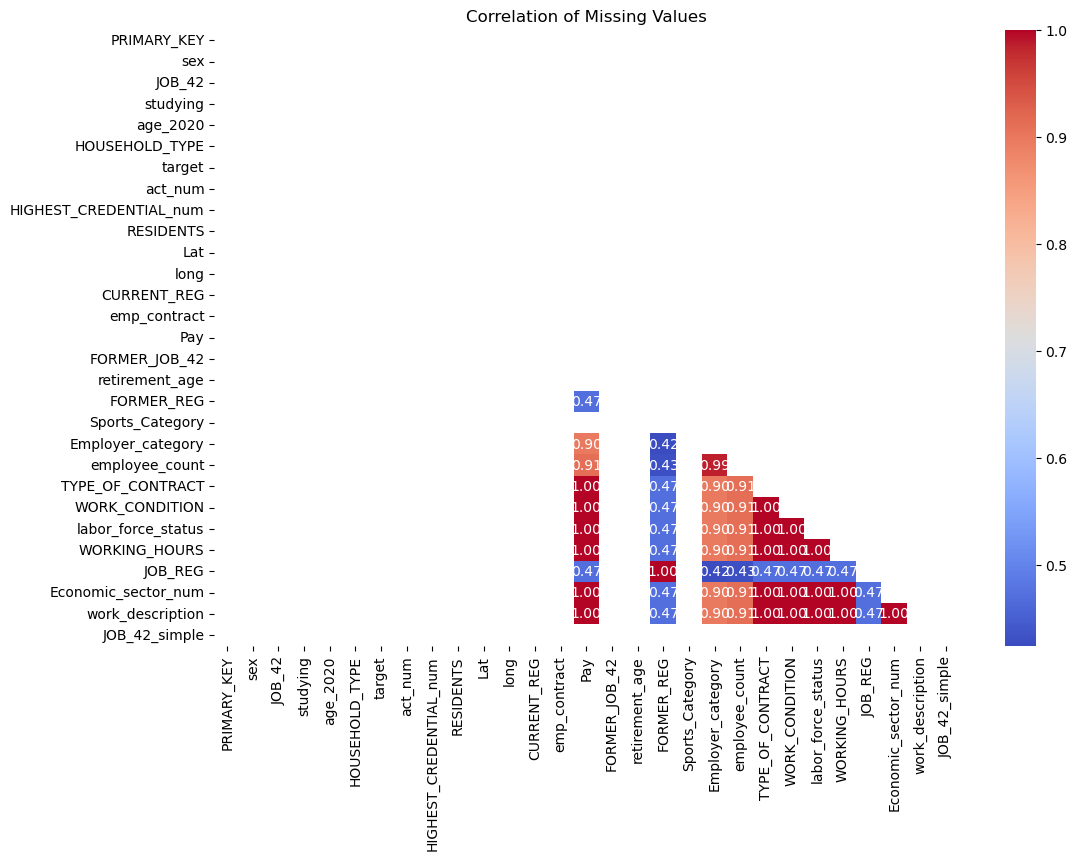

In [27]:
print("Correlation of Missing Values for Learn Data")
plot_na_correlation(learn_data)

#print("Correlation of Missing Values for Test Data")
#plot_na_correlation(test_data)

In [33]:
def nb_na_values_per_rows(df):
    """
    Group rows with exactly X missing values by JOB_42 categories 
    """

    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with exactly 1 missing value
    filtered_df = df[df['missing_count'] == 1].copy() #adjust accordingly

    # Identify all columns with missing values for each row
    filtered_df['Missing_Variables'] = filtered_df.apply(
        lambda row: ', '.join(row.index[row.isnull()].tolist()), axis=1
    )

    # Group by JOB_42 and calculate counts of rows with 1 missing value
    job_42_counts = filtered_df.groupby('JOB_42').size().reset_index(name='Count')

    # Calculate total individuals per JOB_42
    total_counts = df['JOB_42'].value_counts().reset_index()
    total_counts.columns = ['JOB_42', 'Total']

    # Merge with filtered counts to calculate percentages
    job_42_summary = pd.merge(job_42_counts, total_counts, on='JOB_42')
    job_42_summary['Percentage'] = ((job_42_summary['Count'] / job_42_summary['Total']) * 100).round(1)

    # Add a list of all missing variables per JOB_42 category
    missing_variable_summary = (
        filtered_df.groupby('JOB_42')['Missing_Variables']
        .apply(lambda x: ', '.join(x.unique()))
        .reset_index()
    )
    missing_variable_summary.columns = ['JOB_42', 'Employer_category']

    # Merge the summary with the missing variable details
    result = pd.merge(job_42_summary, missing_variable_summary, on='JOB_42')

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)

    return result.sort_values(by='Percentage', ascending=False)

In [34]:
nb_values = nb_na_values_per_rows(learn_data)
print(nb_values)

     JOB_42  Count  Total  Percentage                 Employer_category
15  csp_6_8     38    801         4.7                 Employer_category
6   csp_5_3     13    570         2.3  WORKING_HOURS, Employer_category
19  csp_7_8     63   3375         1.9                 Employer_category
14  csp_6_7     19   1319         1.4                 Employer_category
13  csp_6_5      4    422         0.9                 Employer_category
12  csp_6_4      5    706         0.7                 Employer_category
18  csp_7_7     21   4288         0.5  Employer_category, WORKING_HOURS
9   csp_5_6      7   1935         0.4                 Employer_category
0   csp_3_3      2    481         0.4                     WORKING_HOURS
10  csp_6_2      4    929         0.4                 Employer_category
8   csp_5_5      3   1256         0.2                 Employer_category
11  csp_6_3      3   1376         0.2                 Employer_category
7   csp_5_4      4   1642         0.2                 Employer_c

In [30]:
def na_values_by_group_for_column(df, group_col, target_col):
    # Group by `group_col` and calculate missing values for `target_col`
    grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())
    total_rows = df.groupby(group_col).size()  # Total rows per group
    missing_percent = (grouped / total_rows) * 100  # Calculate % of missing values

    # Combine counts and percentages into one DataFrame
    missing_table = pd.DataFrame({
        'Missing Values': grouped,
        '% of Total Values': missing_percent
    }).round(1)
    
    return missing_table

In [35]:
missing_job_reg_by_household = na_values_by_group_for_column(learn_data, "JOB_42", "Employer_category")
missing_job_reg_by_household

C:\Users\graci\AppData\Local\Temp\ipykernel_3480\1417787162.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())


,Missing Values,% of Total Values
JOB_42,,
csp_1_1,264,100.0
csp_1_2,31,100.0
csp_1_3,90,100.0
csp_2_1,741,94.6
csp_2_2,643,92.7
csp_2_3,181,100.0
csp_3_1,489,91.2
csp_3_3,190,39.5
csp_3_4,157,21.4


In [31]:
#learn_data["work_description"].value_counts()

# Sorting for numeric

In [32]:
learn_data["TYPE_OF_CONTRACT"].value_counts()

TYPE_OF_CONTRACT
CDI           26864
Unemployed    12727
AUT            1573
CDD             987
TTP             472
APP             300
TOA             181
Name: count, dtype: int64

In [33]:
columns_to_factorize = [  
    'JOB_42', 'JOB_REG', 'Economic_sector_num', 'work_description', 'employee_count',
    'retirement_age', 'FORMER_REG', 'TYPE_OF_CONTRACT', 'FORMER_JOB_42',
    'WORK_CONDITION', 'labor_force_status', 'emp_contract', 'Employer_category'
]  

# Function to sort and factorize columns while keeping missing values as NaN
def sort_and_factorize_with_na(data, columns):
    for column in columns:
        # Sort by the column while keeping NaN values intact
        data = data.sort_values(by=column, ascending=True, na_position='first')
        
        # Get factorized codes, skipping NaN values
        codes, uniques = pd.factorize(data[column], use_na_sentinel=True)
        
        # Assign codes to the column, replacing -1 (representing NaN) back with NaN
        data[column] = pd.Series(codes, index=data.index).replace(-1, pd.NA)
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('category')
        
    return data.sort_values(by='PRIMARY_KEY', ascending=True)

# Apply the function to learn_data and test_data
learn_data = sort_and_factorize_with_na(learn_data, columns_to_factorize)
test_data = sort_and_factorize_with_na(test_data, columns_to_factorize)  

# Handling NA 

In [76]:
# Define job-specific pay and working hours
job_defaults = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

# Function to fill missing values for Pay and WORKING_HOURS
def fill_job_defaults(data, job_defaults):
    for job, defaults in job_defaults.items():
        if job == 'csp_1':
            # Special case: Handle 'startswith' condition for 'csp_1'
            job_condition = data['JOB_42'].astype(str).str.startswith(job)
        else:
            # Exact match for other job keys
            job_condition = data['JOB_42'] == job
        
        # Fill missing Pay and WORKING_HOURS
        data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
        data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']

# Apply the function to the datasets
fill_job_defaults(learn_data, job_defaults)
fill_job_defaults(test_data, job_defaults)

# Imputing NA for rows with only 1 NA

In [79]:
def impute_employer_category_with_1_missing(data):
    # Create a column that tracks if there is exactly one missing value per row
    data['missing_count'] = data.isnull().sum(axis=1)

    # Filter rows where there is exactly 1 missing value, and the missing value is in the 'Employer_category' column
    rows_with_1_missing_in_employer = data[data['missing_count'] == 1].index

    # If there are no such rows, just return the original data
    if rows_with_1_missing_in_employer.empty:
        data.drop(columns=['missing_count'], inplace=True)
        return data

    # Apply KNN Imputation only to rows where 'Employer_category' is missing
    knn_imputer = KNNImputer(n_neighbors=5)

    # Select only the rows where 'Employer_category' is missing
    encoded_df = data.loc[rows_with_1_missing_in_employer, ['Employer_category']]

    # Apply KNN imputation to the 'Employer_category' column
    imputed_array = knn_imputer.fit_transform(encoded_df)

    # Round and convert to integer (if necessary) to match original data type
    imputed_values = imputed_array.round().astype(int)

    # Update the original data with imputed values for 'Employer_category'
    data.loc[rows_with_1_missing_in_employer, 'Employer_category'] = imputed_values

    # Drop the temporary 'missing_count' column
    data.drop(columns=['missing_count'], inplace=True)

    return data



In [ ]:
# Apply the function to learn_data
impute_employer_category_with_1_missing(learn_data)

In [83]:
def impute_working_hours_with_1_missing_values(df):
    """
    Imputes missing values by median within each JOB_42 category for rows with exactly 1 missing value (so WORKING HOURS)
    """
    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with exactly 1 missing value
    filtered_df = df[df['missing_count'] == 1]

    # Iterate through rows with 1 missing value
    for index, row in filtered_df.iterrows():
        # Find the missing column
        missing_col = row[row.isnull()].index[0]

        # Get the JOB_42 category
        job_42_category = row['JOB_42']

        # Calculate the median of the missing column for the specific JOB_42 category
        median_value = df[df['JOB_42'] == job_42_category][missing_col].median()

        # Impute the missing value with the calculated median
        df.at[index, missing_col] = median_value

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)

    return df

In [ ]:
impute_working_hours_with_1_missing_values(learn_data)

# Imputing NA for rows with 2 NA

In [286]:
# Add section here to replace missing JOB_REG with CURRENT_REG for some JOB_42 categories
# - eg artisans, agriculture...!!!!!!!!!!!!!!!!

In [ ]:
print(missing_values_table(learn_data)) 
print(missing_values_table(test_data))

# MICE

## Enconding the dataset to ease imputation and use of ML models

In [101]:
#for linear regression (MICE, KNN) I need only number :

#do one-hot encoding for "labor_force status", but with catagegory being 0(=??), Employed_missing, Unemployed and Other (=only being 6%)
#do one hot-encodung for "type_of_contratct" with CDI, Unemployed, Employed_Missing, Other (=only being 12%)
#do one_hot_encding for "work_condition" with Unemployed, P, Other(=only being 17%)
#do one hot_econding for "emp_contract", with EMP1-6, Unemployed, EMP2-1, Other (=being 12%)
#do one hot encoding for "sport" but with a "Other" category
#do one hot encdoding for "employer_category" with 1 to 7 being "Others"
#for "act" do one hot encoding but maybe merge stay at home people with inactif + drop less than 14years olds as nobody in our data is 

#use "work condition" instead of JOB_42 and then do one-hot-encdoding
#do one-hot-encoding for "household_type"
#do one hot encoding for "Economic_sector_num" and "work_description" 
#do one hot encdoding for "REG_JOB" and "FORMER_REG"

#can keep it as is for "employee count" because here the ordinality make sense
#can keep as is for "highest_credential" because the ordinality make sense here for education
#can keep as is for the location of insee code because here the ordinality make sense

## Building the pipeline

# Pipeline - new ver

In [38]:
class FillJobDefaults(BaseEstimator, TransformerMixin):
    def __init__(self, job_defaults):
        self.job_defaults = job_defaults
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = X.copy()
        for job, defaults in self.job_defaults.items():
            if job == 'csp_1':
                job_condition = data['JOB_42'].astype(str).str.startswith(job)
            else:
                job_condition = data['JOB_42'] == job
            data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
            data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']
        return data

In [58]:
class ImputeEmployerCategoryWith1Missing(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
    
    def fit(self, X, y=None):
        # Identify numeric columns for KNN calculation
        self.numeric_cols_ = X.select_dtypes(include=['int64', 'float64']).columns
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify rows with exactly 1 missing value in Employer_category
        X_copy['missing_count'] = X_copy.isnull().sum(axis=1)
        rows_with_1_missing = X_copy[
            (X_copy['missing_count'] == 1) & 
            (X_copy['Employer_category'].isnull())
        ]
        
        # If no such rows, return original data
        if rows_with_1_missing.empty:
            X_copy.drop(columns=['missing_count'], inplace=True)
            return X_copy
        
        # Prepare data for KNN - use only numeric columns
        impute_data = X_copy[self.numeric_cols_].copy()
        
        # KNN imputation using only numeric columns
        imputed_numeric = self.knn_imputer.fit_transform(impute_data)
        
        # Update numeric columns with imputed values for rows with 1 missing
        X_copy.loc[rows_with_1_missing.index, self.numeric_cols_] = imputed_numeric[rows_with_1_missing.index]
        
        # Clean up
        X_copy.drop(columns=['missing_count'], inplace=True)
        return X_copy

In [40]:
class ImputeWorkingHoursByJob(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['missing_count'] = X.isnull().sum(axis=1)
        filtered_df = X[X['missing_count'] == 1]

        for index, row in filtered_df.iterrows():
            if pd.isnull(row['WORKING_HOURS']):
                job_42_category = row['JOB_42']
                median_value = X[X['JOB_42'] == job_42_category]['WORKING_HOURS'].median()
                X.at[index, 'WORKING_HOURS'] = median_value

        X.drop(columns=['missing_count'], inplace=True)
        return X

In [62]:
# Custom Transformer for rows with 2 missing values
class ImputeRowsWithTwoMissing(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    def fit(self, X, y=None):
        # Identify numeric columns for KNN calculation
        self.numeric_cols_ = X.select_dtypes(include=['int64', 'float64']).columns
        return self
    
    def transform(self, X):
        data = X.copy()
        data['missing_count'] = data.isnull().sum(axis=1)
        rows_with_2_missing = data[data['missing_count'] == 2].drop(columns='missing_count')
        if not rows_with_2_missing.empty:
            imputed_array = self.knn_imputer.fit_transform(rows_with_2_missing)
            imputed_df = pd.DataFrame(imputed_array, columns=rows_with_2_missing.columns, index=rows_with_2_missing.index)
            
            # Ensure categorical types are restored correctly
            for col in imputed_df.columns:
                if isinstance(data[col].dtype, pd.CategoricalDtype):
                    original_categories = data[col].cat.categories
                    
                    # Round and cast imputed values to integers
                    imputed_df[col] = imputed_df[col].round().astype(int)
                    
                    # Add missing categories dynamically
                    new_categories = pd.Categorical(imputed_df[col], categories=original_categories)
                    imputed_df[col] = new_categories
                    
                else:
                    imputed_df[col] = imputed_df[col]
            
            data.loc[rows_with_2_missing.index, :] = imputed_df
        data.drop(columns=['missing_count'], inplace=True)
        return data

In [64]:
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, max_iter=10, random_state=42):
        self.columns_to_impute = columns_to_impute
        self.max_iter = max_iter
        self.random_state = random_state
        self.mice_imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)
    
    def fit(self, X, y=None):
        self.mice_imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        X = X.copy()
        imputed_data = self.mice_imputer.transform(X[self.columns_to_impute])
        imputed_df = pd.DataFrame(imputed_data, columns=self.columns_to_impute, index=X.index)
        imputed_df = imputed_df.round(0)
        X[self.columns_to_impute] = imputed_df
        return X

In [65]:
job = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

col_to_impute = [
        'Employer_category', 'employee_count', 'WORKING_HOURS', 
        'Pay', 'TYPE_OF_CONTRACT', 'WORK_CONDITION', 
        'labor_force_status', 'Economic_sector_num', 'work_description',
        'FORMER_REG', 'JOB_REG'
    ]


pipeline = Pipeline([
    ('fill_job_w_ext_data', FillJobDefaults(job_defaults=job)),
    ('impute_employer', ImputeEmployerCategoryWith1Missing(n_neighbors=5)),
    ('impute_working_hours', ImputeWorkingHoursByJob()),
    ('impute_two_missing', ImputeRowsWithTwoMissing(n_neighbors=5)),
    ('mice_imputer', MICEImputer(columns_to_impute=col_to_impute))
])

# Apply the pipeline to your dataset
processed_data = pipeline.fit_transform(learn_data)

ValueError: could not convert string to float: 'csp_4_2'

In [ ]:
print(missing_values_table(learn_data)) 

# Pipelineeeeee

In [96]:
class ImputeEmployerCategoryWith1Missing(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.knn_imputer = None  # Will be initialized during fitting

    def fit(self, X, y=None):
        # Create a KNN imputer and fit it only on rows with 1 missing value in 'Employer_category'
        self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
        
        # Filter rows where 'Employer_category' is missing and exactly one column is missing
        X_fit = X.copy()
        X_fit['missing_count'] = X_fit.isnull().sum(axis=1)
        rows_with_1_missing_in_employer = X_fit[
            (X_fit['missing_count'] == 1) & X_fit['Employer_category'].isnull()
        ]
        
        # If no rows satisfy this condition, fit is a no-op
        if not rows_with_1_missing_in_employer.empty:
            # Fit the imputer only on relevant rows and columns
            encoded_df = rows_with_1_missing_in_employer[['Employer_category']]
            self.knn_imputer.fit(encoded_df)
        
        return self

    def transform(self, X):
        # Make a copy of the input data to avoid modifying the original
        X = X.copy()

        # Add a column to track the number of missing values per row
        X['missing_count'] = X.isnull().sum(axis=1)

        # Identify rows where there is exactly 1 missing value in 'Employer_category'
        rows_with_1_missing_in_employer = X[
            (X['missing_count'] == 1) & X['Employer_category'].isnull()
        ].index

        # If no such rows exist, return the original DataFrame
        if rows_with_1_missing_in_employer.empty:
            X.drop(columns=['missing_count'], inplace=True)
            return X

        # Select the relevant rows and columns for imputation
        encoded_df = X.loc[rows_with_1_missing_in_employer, ['Employer_category']]

        # Apply the pre-fitted KNN imputer
        imputed_array = self.knn_imputer.transform(encoded_df)

        # Update the original DataFrame with the imputed values
        X.loc[rows_with_1_missing_in_employer, 'Employer_category'] = imputed_array.round().astype(int)

        # Drop the temporary 'missing_count' column
        X.drop(columns=['missing_count'], inplace=True)

        return X


In [98]:
class ImputeWorkingHoursWith1Missing(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute missing values in the 'WORKING_HOURS' column 
    by the median within each JOB_42 category for rows with exactly 1 missing value.
    """
    def __init__(self):
        self.medians = {}

    def fit(self, X, y=None):
        """
        Calculate the medians for the 'WORKING_HOURS' column grouped by the JOB_42 category.
        """
        X_copy = X.copy()

        # Calculate and store the median for the 'WORKING_HOURS' column by JOB_42 category
        self.medians = X_copy.groupby('JOB_42')['WORKING_HOURS'].median()

        return self

    def transform(self, X):
        """
        Impute missing values in the 'WORKING_HOURS' column for rows with exactly 1 missing value,
        using the precomputed medians from the fit step.
        """
        X = X.copy()

        # Count the number of missing values per row
        X['missing_count'] = X.isnull().sum(axis=1)

        # Filter rows with exactly 1 missing value
        rows_with_1_missing = X[X['missing_count'] == 1]

        # Iterate through rows with exactly 1 missing value
        for index, row in rows_with_1_missing.iterrows():
            # Check if the missing value is in 'WORKING_HOURS'
            if pd.isnull(row['WORKING_HOURS']):
                # Get the JOB_42 category for the row
                job_42_category = row['JOB_42']

                # Get the precomputed median value for the JOB_42 category
                median_value = self.medians.get(job_42_category, None)

                # Impute the missing value with the median if it exists
                if pd.notnull(median_value):
                    X.at[index, 'WORKING_HOURS'] = median_value

        # Drop the temporary 'missing_count' column
        X.drop(columns=['missing_count'], inplace=True)

        return X


In [ ]:
pipeline = Pipeline([
    ('impute_employer', ImputeEmployerCategoryWith1Missing(n_neighbors=5)),
    #('impute_working_hours', ImputeWorkingHoursWith1Missing()),
    # Add other pipeline steps here
])

# Fit the pipeline on the training data
train_processed = pipeline.fit_transform(learn_data)

# Prediction

## LINEAR MODEL

In [ ]:
#the encoding is done using the previous function (encoding_datataset)

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 

In [ ]:
#move this for after train test splitting
learn_lin = pipeline.fit_transform(learn_data)

In [38]:
x_train_lin = learn_lin.drop(columns=["target"])
y_train_lin = learn_lin["target"]

In [39]:
X_train_lin, X_test_lin, Y_train_lin, Y_test_lin = train_test_split(x_train_lin,
                                                    y_train_lin, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# Example GridSearchCV for Linear Regression
param_grid = {'fit_intercept': [True, False]}  # Define your hyperparameter grid

# Create a Linear Regression model
lr = LinearRegression()

# Perform grid search with cross-validation
lin_res = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV model
lin_res.fit(X_train_lin, Y_train_lin)

# Output the best model and its score
print(f"Best model: {lin_res.best_estimator_}")
print(f"Best score: {lin_res.best_score_}")


In [ ]:
train_predictions = lin_res.predict(X_train_lin)
print("R² for training set: ", r2_score(Y_train_lin, train_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_lin, lin_res.predict(X_train_lin)))

In [ ]:
train_predictions = lin_res.predict(X_train_lin)
test_predictions = lin_res.predict(X_test_lin)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_lin, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_lin.min(), y_train_lin.max()], [y_train_lin.min(), y_train_lin.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_linear.png", format='png', dpi=300)  
plt.show()

## RANDOM FOREST

In [36]:
#learn_rf = pipeline.fit_transform(learn_data)

In [106]:
x_train_rf = learn_data.drop(columns=["target"])
y_train_rf = learn_data["target"]

X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(x_train_rf,
                                                    y_train_rf, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [108]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [5, 10, 30, 50],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [110]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train_rf, Y_train_rf)

In [ ]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

In [ ]:
cv_scores = cross_val_score(best_model_rf, X_train_rf, Y_train_rf, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Average R2: {np.mean(cv_scores):.2f}")

In [ ]:
train_predictions = best_model_rf.predict(X_train_rf)
test_predictions = best_model_rf.predict(X_test_rf)

print("R² for training set: ", r2_score(Y_train_rf, train_predictions))
print("R² for test set: ", r2_score(Y_test_rf, test_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf)))
print("RMSE on the test set:", root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf)))

In [114]:
error_metrics = pd.DataFrame({
    'Metric': ['R²', 'RMSE'],
    'Train': [r2_score(Y_train_rf, train_predictions), root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf))],
    'Test': [r2_score(Y_test_rf, test_predictions), root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf))]
})

# Set 'Metric' as the index to have a clean format
error_metrics.set_index('Metric', inplace=True)

# Convert to LaTeX format
error_metrics_table = error_metrics.to_latex(index=True, float_format="%.2f")

with open("./error_metrics.tex", "w") as file:
    file.write(error_metrics_table)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_rf, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_rf.min(), y_train_rf.max()], [y_train_rf.min(), y_train_rf.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_rf.png", format='png', dpi=300)  
plt.show()

## EXTRA ANALYISIS

In [ ]:
# Calculate correlation
correlation_matrix = learn_data.corr()

# Find correlations with the target variable
target_corr = correlation_matrix['target'].sort_values(ascending=False)

print(target_corr)

target_corr_table = target_corr.to_latex(index=False, float_format="%.2f")

with open("./target_corr.tex", "w") as file:
    file.write(target_corr_table)

In [ ]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': x_train_rf.columns,
    'Importance': best_model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

feature_importances_table = feature_importances.to_latex(index=False, float_format="%.2f")

with open("./feature_importances.tex", "w") as file:
    file.write(feature_importances_table)